In [1]:
import pickle
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from datetime import datetime
import math as m

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# Carregar dados
with open('df_pedidos_baixados_2020_a_2023_processado.pkl', 'rb') as file:
    dados = pickle.load(file)
dados = dados[dados.Ano>=2021]

In [4]:
dados.shape

(146082, 8)

In [5]:
percentual_de_recorte = 95  # Ajustar aqui para recortar
#oportunidade de melhoria: nao descartar esses dados, usar para amostrar os "outros"
recorte_amostral = dados.query(f'PercentualAcumulado_2020_2023 <= {percentual_de_recorte}')\
                        .sort_values(by=['PercentualAcumulado_2020_2023']).copy()
print(recorte_amostral.OrgaoDestinatario.unique().shape)

percentual_limite = 70 # Ajustar aqui para definir os "Outros" (percentual_de_recorte-percentual_limite)
recorte_amostral['Orgao_alvo'] = recorte_amostral.apply(lambda row: row['OrgaoDestinatario'] 
                               if row['PercentualAcumulado_2020_2023'] <= percentual_limite else 'Outros', axis=1)
recorte_amostral = recorte_amostral[['Orgao_alvo', 'Mês', 'Dia da Semana', 'DetalhamentoSolicitacao']]
print(recorte_amostral.shape)
print(recorte_amostral.Orgao_alvo.unique().shape) # qtd de classes

(178,)
(139027, 4)
(47,)


In [6]:
# Vetorização TF-IDF
max_features_tfidf=14000
max_df=0.1
min_df=0.0001
ngram_range=(1,1)
vectorizer = TfidfVectorizer(max_features=max_features_tfidf, max_df=max_df, min_df=min_df, ngram_range=ngram_range)
X_tfidf = vectorizer.fit_transform(recorte_amostral['DetalhamentoSolicitacao'])

# Codificação dos rótulos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(recorte_amostral['Orgao_alvo'])

y_encoded = torch.tensor(y_encoded, dtype=torch.long)
y_encoded = nn.functional.one_hot(y_encoded) 

# Codificação dos parâmetros adicionais: mês e dia da semana
onehot_encoder = OneHotEncoder()
mes_dia_semana_encoded = onehot_encoder.fit_transform(recorte_amostral[['Mês', 'Dia da Semana']])
print(X_tfidf.shape)

(139027, 13845)


In [7]:
# Definindo conjunto de dados personalizado para PyTorch
class CustomDataset(Dataset):
    def __init__(self, X_tfidf, mes_dia_semana, y):
        self.X_tfidf = X_tfidf
        self.mes_dia_semana = mes_dia_semana
        self.y = y

    def __len__(self):
        return len(self.X_tfidf)

    def __getitem__(self, idx):
        return self.X_tfidf[idx], self.mes_dia_semana[idx], self.y[idx]

In [8]:
# Divisão em conjunto de treinamento e teste
X_train_tfidf, X_test_tfidf, y_train, y_test, mes_dia_semana_train, mes_dia_semana_test = train_test_split(
    X_tfidf, y_encoded, mes_dia_semana_encoded, test_size=0.99, random_state=42, stratify=y_encoded)

# Convertendo os dados para tensores densos
X_train_tfidf_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32) 
X_test_tfidf_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32) 
mes_dia_semana_train_tensor = torch.tensor(mes_dia_semana_train.toarray(), dtype=torch.float32) 
mes_dia_semana_test_tensor = torch.tensor(mes_dia_semana_test.toarray(), dtype=torch.float32) 
y_train_tensor = y_train 
y_test_tensor = y_test 

# Criando DataLoader para conjuntos de treinamento e teste
train_dataset = CustomDataset(X_train_tfidf_tensor, mes_dia_semana_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = CustomDataset(X_test_tfidf_tensor, mes_dia_semana_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
# Inicializando o modelo
input_tfidf_shape = X_train_tfidf.shape[1]
input_mes_dia_semana_shape = mes_dia_semana_train.shape[1]
output_shape = y_encoded.shape[1]
#model = NeuralNetwork(input_tfidf_shape, input_mes_dia_semana_shape, output_shape).to(device) #####

In [10]:
# Função para avaliação do modelo
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    total_loss = 0
    
    with torch.no_grad():
        
        for data in test_loader:
            
            inputs_tfidf, inputs_mes_dia_semana, labels = data
            inputs_tfidf = inputs_tfidf.to(device) #####             #####
            inputs_mes_dia_semana = inputs_mes_dia_semana.to(device) #####
            labels = labels.to(device) #####                         #####
            
            outputs = model(inputs_tfidf.float(), inputs_mes_dia_semana.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == torch.max(labels, 1)[1]).sum().item()
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(torch.max(labels, 1)[1].cpu().numpy())

            loss = criterion(outputs, torch.max(labels, 1)[1])
            total_loss += loss.item()
    
    accuracy = correct / total
    avg_loss = total_loss / len(test_loader)
    
    return accuracy, avg_loss, y_true, y_pred

In [11]:
# Função para treinamento do modelo
def train(model, train_loader, test_loader, criterion, optimizer, 
          epochs=50, use_best_model=False, early_stop=False, es_range=1.0, show_trn_stats=True): 
    
    score=9999
    
    if use_best_model:
        best_score = 9999
        best_epoch = 0
        best_model_wts = copy.deepcopy(model.state_dict())
    
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        
        for data in train_loader:
            inputs_tfidf, inputs_mes_dia_semana, labels = data
            inputs_tfidf = inputs_tfidf.to(device) #####             #####
            inputs_mes_dia_semana = inputs_mes_dia_semana.to(device) #####
            labels = labels.to(device) #####                         #####
            optimizer.zero_grad()
            outputs = model(inputs_tfidf, inputs_mes_dia_semana)
            loss = criterion(outputs, torch.max(labels, 1)[1]) 
            #loss = criterion(outputs, labels.float()) 
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        if use_best_model or early_stop or show_trn_stats:
            accuracy, avg_loss, y_true, y_pred = evaluate_model(model, test_loader, criterion)
            precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
            recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
            f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
            score_anterior = score
            score = avg_loss
            print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):,.5f}", 
                   f"Acc: {accuracy:,.5f}", 
                   f"Prc: {precision:,.5f}", 
                   f"Rcl: {recall:,.5f}", 
                    f"F1: {f1:,.5f}", 
                  f"Test_loss: {avg_loss:,.5f}")
            #print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):,.5f}, Score: {score:,.5f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):,.5f}")
        
        if use_best_model:
            if score < best_score: 
                best_epoch = epoch+1
                best_score = score
                best_model_wts = copy.deepcopy(model.state_dict())
                   
        if use_best_model and early_stop and score > best_score*es_range: 
            print(f"Interrompendo o treinamento...")
            break
        
        if early_stop and score >= score_anterior*es_range: # loss >
            print(f"Interrompendo o treinamento...")
            break
            
    # Limpeza do otimizador (liberacao da memoria gpu)
    optimizer.zero_grad()
    optimizer.state.clear()
    # torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    if use_best_model and best_epoch!=epoch+1:
        model.load_state_dict(best_model_wts)
        print(f"Carregando modelo da melhor epoca - {best_epoch}")
    print(f"Fim.")

In [12]:
# Definindo a função de perda e otimizadores ## weight_decay = regularizacao L2
criterion = nn.CrossEntropyLoss()
#adam001 =   optim.AdamW(model.parameters(), weight_decay=0.1, lr=0.001)  ### padrao weight_decay=1e-2
#adam0001 =   optim.AdamW(model.parameters(), weight_decay=0.1, lr=0.0001)

In [13]:
model = torch.jit.load('modelo_tfidf_F1_0.92567_Loss_0.30878_20240524_214716.pt')
model.eval()

RecursiveScriptModule(
  original_name=NeuralNetwork
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (dropout): RecursiveScriptModule(original_name=Dropout)
  (logsoftmax): RecursiveScriptModule(original_name=LogSoftmax)
)

In [14]:
# Avaliação do modelo nos dados de teste
accuracy, avg_loss, y_true, y_pred = evaluate_model(model, test_loader, criterion)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
print(f"Acurácia: {accuracy:,.5f}", f"Precisão: {precision:,.5f}", 
      f"Recall: {recall:,.5f}", f"F1-score: {f1:,.5f}", f"Test_loss: {avg_loss:,.5f}")

Acurácia: 0.83342 Precisão: 0.86702 Recall: 0.83342 F1-score: 0.83437 Test_loss: 0.67049


<Figure size 1500x1200 with 0 Axes>

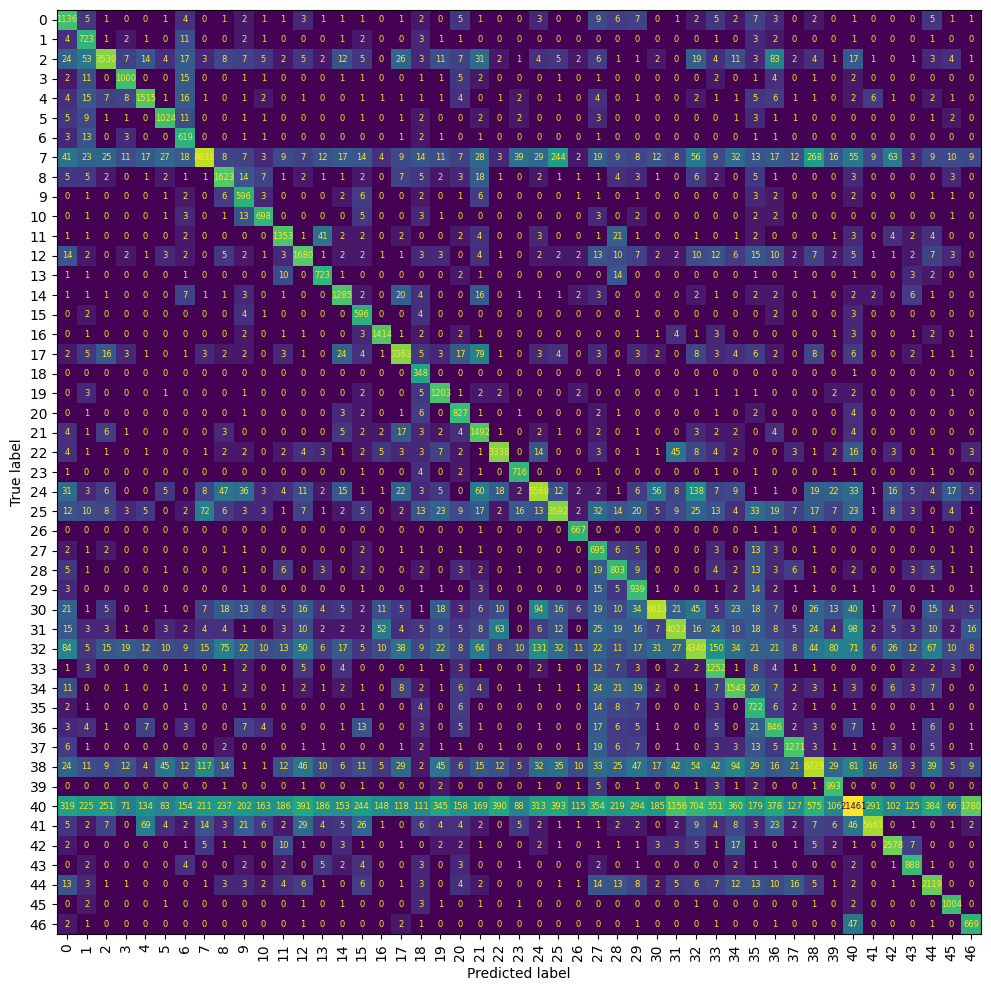

In [15]:
# Calculando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)
# Criando a exibição da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.rcParams["figure.figsize"] = (15,12)
# Definindo o tamanho da figura
plt.figure(figsize=(15, 12))
# Obtendo a imagem da matriz de confusão com uma escala de cores personalizada
im = disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d', colorbar=False)

################### Ajustando as cores para a escala logarítmica #################################
im = plt.imshow(conf_matrix, interpolation='nearest', cmap='viridis', norm=LogNorm())
# Adicionando a barra de cores
#plt.colorbar(im)
# Ajustando o tamanho da fonte manualmente
for text in im.axes.texts:
    text.set_fontsize(6)
# Exibindo a figura
plt.show()

In [18]:
print(label_encoder.inverse_transform([2]))
print(label_encoder.inverse_transform([7]))
print(label_encoder.inverse_transform([24]))
print(label_encoder.inverse_transform([25]))
print(label_encoder.inverse_transform([30]))
print(label_encoder.inverse_transform([31]))
print(label_encoder.inverse_transform([32]))
print(label_encoder.inverse_transform([38]))
print(label_encoder.inverse_transform([40]))

['ANEEL – Agência Nacional de Energia Elétrica']
['ANVISA – Agência Nacional de Vigilância Sanitária']
['INSS – Instituto Nacional do Seguro Social']
['MAPA - Ministério da Agricultura e Pecuária']
['MDS - Ministério do Desenvolvimento e Assistência Social, Família e Combate à Fome']
['MEC – Ministério da Educação']
['MF - Ministério da Fazenda']
['MS – Ministério da Saúde']
['Outros']
